## EDA on Process data

In this notebook I wil be conducting some Exploratory Data Analysis on the Process Data. I will be primarily focusing on generating interesting visualisations to give us an an alternative and hopefully interesting visual guide to our data to help us identify anything that might be useful during the project that will help us achieve our planned goals.

I will import all packages required for use in the notebook at the beginning rather than when they are required in order to save import time when conducting computations.

In [1]:
import pandas as pd
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
from sys import getsizeof as ram
import networkx as nx
from pyvis.network import Network

Here I will define useful functions that I might call back to later in the notebook. This is a quality of life addition that prevents me having to regularly copy and paste chunks of code, or type out large blocks each time. The main functions I define make it simpler for me to implement `datetime` into my code blocks, allowing me to measure how long a computation takes to complete; this is very useful in this exploratory phase to get an idea of what functions are useful and should continue to be used and what might be overly complex and waste of time to run consistently.

In [2]:
start = 0
def dtn():
    """Sets start variable to the current date and time
    
    IMPORTANT: must define global start variable before using"""
    global start
    start = dt.now()
    
def end():
    """Using in conjunction with dtn() function, returns the time taken between dtn() and this function being called"""
    return str(dt.now()-start)

def gen_end():
    """Generic function that gives a string telling how long it has been since dtn() was called. Can be used instead of end()"""
    stop = end()
    print("Completed in :"+stop)

Next we will read in our Process Data. This block of code first reads to see if the data is found on the local hardrive (eliminating the need for downloading, and therefore speeding up the process) and takes the Error of a file not being found as an exception, and then proceeds to download from data hosted on the web at dropbox. If using this on your own PC and want faster results having already downloaded the data, please change the path to where your copy of the data can be found.

In [3]:
try:
    print("Looking for local copy of data...")
    dtn()
    df_p = pd.read_csv("G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/Advanced-Cyber-Analytics-for-Attack-Detection/Data/Process data.gz",compression="gzip")
    stop = end()
    print("Data fetched locally in "+stop)
except OSError as e:
    if e.errno == 2:
        print("No Local data found. Importing from the web.")
        dtn()
        df_p = pd.read_csv("https://www.dropbox.com/s/c065rcq72abzm0s/Process_data.gz?dl=1",compression="gzip")
        stop = end()
        print("Data fetched from web in "+stop)
    else:
        print(e)

Looking for local copy of data...
Data fetched locally in 0:01:12.935828


Once the data is imported we take a brief look at what our data looks like.

In [4]:
df_p.head()

,Unnamed: 0,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,1,Comp563664$,Comp563664,rundll32.exe,services,1
2,2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,4,Comp157389$,Comp157389,Proc402696.exe,services,1


In [5]:
df_p.tail()

,Unnamed: 0,UserName,Device,ProcessName,ParentProcessName,DailyCount
55981613,251545,Comp738970$,Comp738970,Proc207472.exe,svchost,2
55981614,251546,User925794,Comp097857,cmd.exe,Proc174492,2
55981615,251547,Comp996714$,Comp996714,Proc612297.exe,services,5
55981616,251548,Comp391736$,Comp391736,rundll32.exe,Proc247259,2
55981617,251549,Comp769777$,Comp769777,rundll32.exe,rundll32,3


Here I define the "Data Quality Report" that we used back at the beginning of our course, and then in the next block apply it to our imported data. This report tells us how many of each feature is found (hopefully all the same number), how many unique entries there are, and whether there is any missing data in any of these features. In addition it also tells us the data type of each feature, though a lot of features in cybersecurity end up being "objects" as they are strings, or they are integers or float values.

In [6]:
def data_qual(df):
    global data_quality_report
    #DataFrame with columns
    columns = pd.DataFrame(list(df.columns.values[1:]))

    #DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

    #DataFrame with Count
    data_count = pd.DataFrame(df.count(), columns=['Count'])

    #DataFrame with unique values
    unique_value_counts = pd.DataFrame(columns=['Unique Values'])
    for v in list(df.columns.values):
        unique_value_counts.loc[v] = [df[v].nunique()]

    missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
    data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
    print('Data Quality Report')

In [7]:
data_qual(df_p)
print("Process Data")
data_quality_report

Data Quality Report
Process Data


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,55981618,1213395,0
UserName,object,55981618,25320,0
Device,object,55981618,13476,0
ProcessName,object,55981618,25373,0
ParentProcessName,object,55981618,12226,0
DailyCount,int64,55981618,15374,0


We notice that the first column is completely useless and so drop it.

In [4]:
df_p = df_p.drop(df_p.columns[0],axis=1)

In [9]:
df_p.head()

,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,Comp563664$,Comp563664,rundll32.exe,services,1
2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,Comp157389$,Comp157389,Proc402696.exe,services,1


The below function is not that useful but gives an alternative representation of what is in the data using the `pd.describe` function. However I had to seperate the `int64` data and the `object` data as they do not look good in a dataframe together.

In [10]:
x = []
for i in df_p.columns:
    if i == "DailyCount":
        global df_int
        df_int = df = df_p[str(i)].describe()
    else:
        df = df_p[str(i)].describe()
        x.append(df)
df_desc = pd.concat(x,axis=1)

In [11]:
df_desc

,UserName,Device,ProcessName,ParentProcessName
count,55981618,55981618,55981618,55981618
unique,25320,13476,25373,12226
top,Scanner,EnterpriseAppServer,rundll32.exe,services
freq,255383,451831,2325974,12633664


In [12]:
df_int

count    5.598162e+07
mean     2.602635e+01
std      1.234955e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      9.025670e+05
Name: DailyCount, dtype: float64

### Frequencies

In this subsection I will mostly be looking at the frequency of various variables to get an impression of not necessarily importance but the most common of various features vfound throughout the data.

We start by defining an iterative plock that for each feature counts how many times each different entry appears and adds this to a list which we can then access in order for each variable.

In [9]:
x = ["UserName","Device","ProcessName","ParentProcessName"]
counts = []
for i in x:
    z = df_p.groupby(i).size().sort_values(ascending=False)
    z = pd.DataFrame(z)
    z.reset_index(level=0, inplace=True)
    z.columns = [i,'Count']
    counts.append(z)

Top 15 most frequently occuring UserNames of each feature:

In [14]:
df_counts = pd.concat(counts,axis=1)
df_counts.head(15)

,UserName,Count,Device,Count,ProcessName,Count,ParentProcessName,Count
0,Scanner,255383.0,EnterpriseAppServer,451831.0,rundll32.exe,2325974,services,12633664.0
1,User272607,73934.0,Comp149394,28007.0,cscript.exe,1687233,svchost,5742175.0
2,EnterpriseAppServer$,38552.0,Comp460411,26771.0,Proc857443.exe,1644561,None,4343007.0
3,Administrator,29443.0,Comp978490,25866.0,Proc364675.exe,1499525,Proc089893,3499148.0
4,User414014,18593.0,Comp897269,24757.0,conhost.exe,1231137,taskeng,2496930.0
5,AppService,17675.0,Comp291378,24704.0,dllhost.exe,969474,Proc247259,2361635.0
6,User724397,16334.0,Comp420961,24387.0,wmiprvse.exe,963022,Proc443607,1415832.0
7,Comp916004$,11648.0,Comp133838,23279.0,taskhost.exe,938684,Proc442764,1336381.0
8,Comp943585$,10467.0,Comp664214,22566.0,svchost.exe,866240,cmd,1275235.0
9,User703614,10107.0,Comp354553,21900.0,Proc453954.exe,865180,winlogon,1240798.0


And then another quick check of the unique entries in each feature.

In [15]:
for i in range(0,4):
    print(counts[i].columns[0])
    print("Length = "+str(len(counts[i])))
    print("")

UserName
Length = 25320

Device
Length = 13476

ProcessName
Length = 25373

ParentProcessName
Length = 12226



In the following functions I was trying to take a look at how many in the `UserName` function had over a certain threshold of counts. It struck me that there seems to be very quick fall off in number of occurences, yet a lot of the `UserNames` still have a considerable number of entries. I see that 17999 of the entries occur more than 1000 times out of the 25320 total unique entries.

In [16]:
counts[0].loc[:,"Count"]
i = 0
x = counts[0].loc[:,"Count"][0]
while x > 100:
    x = counts[0].loc[:,"Count"][i]
    i = i + 1
print(i)

23047


In [17]:
counts[0].loc[:,"Count"]
i = 0
x = counts[0].loc[:,"Count"][0]
while x > 1000:
    x = counts[0].loc[:,"Count"][i]
    i = i + 1
print(i)

17999


Following on from the above I decided to plot the fall off of the counts for each feature to get a visual representation. I start off experimenting with the top few where the most dramatic changes happen.

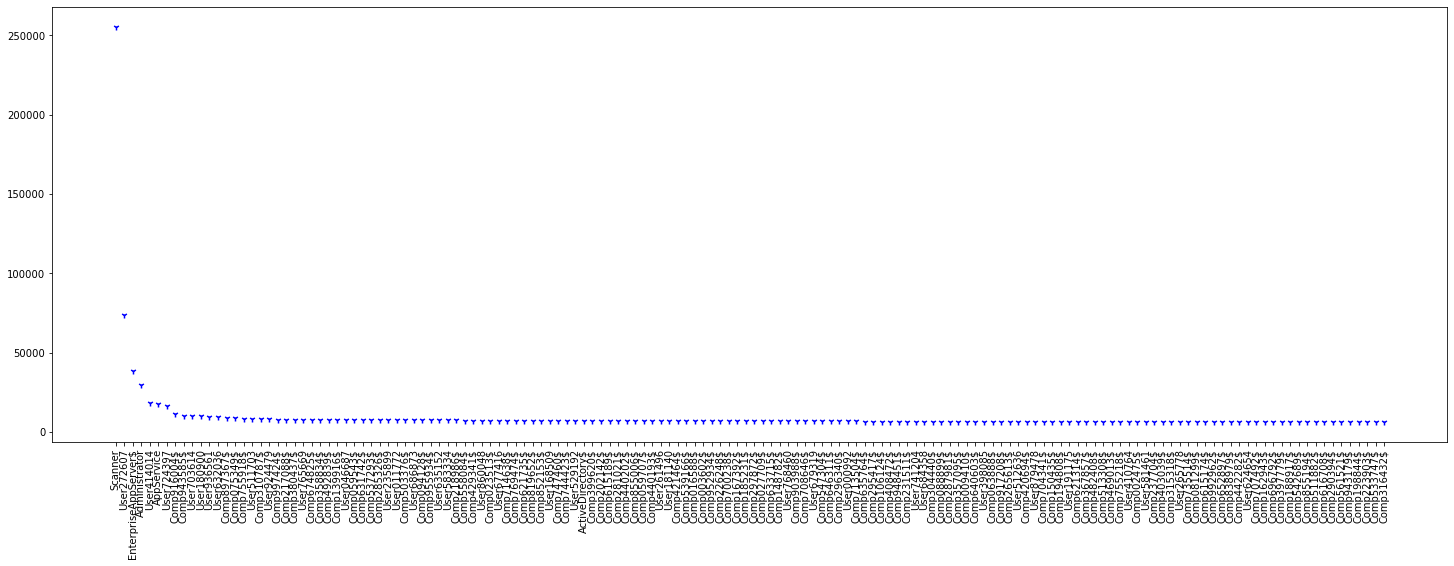

In [21]:
x=counts[0].loc[:,"UserName"].head(150)
y=counts[0].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Blue")
plt.xticks(rotation=90)
plt.savefig("./plots/UserNames_Head_150.png")
plt.show()

I take a look at the tail end of the counts as well as the general trend in the head is that it looks quite flat, however we see that there is actually a steady decrease in entries, with considerably less variation in the least occurent UserNames.

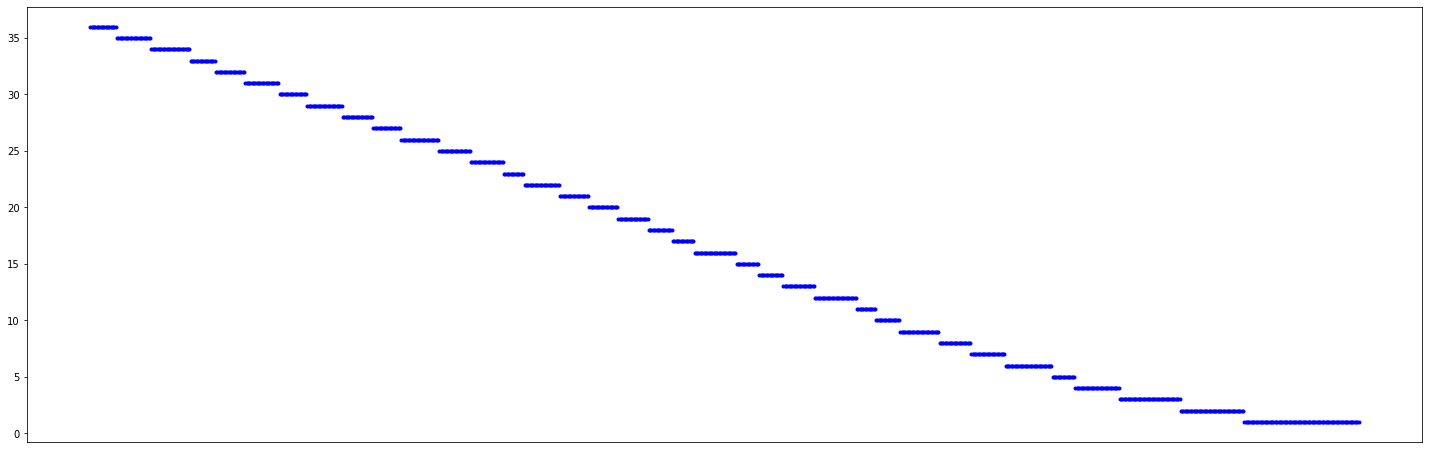

Completed in :0:00:02.291373


In [24]:
dtn()
x=counts[0].loc[:,"UserName"].tail(1000)
y=counts[0].loc[:,"Count"].tail(1000)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker=".",c="Blue")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/UserNames_Tail_1000.png")
plt.show()
gen_end()

I then decided it would be worth plotting all of the data to get an impression for the shape, even if it is hard to distinguish individual values - especially as I removed the x-axis labels. The first time I tried to plot this it took a long time but removing the x-axis label decreased the computation time significantly.

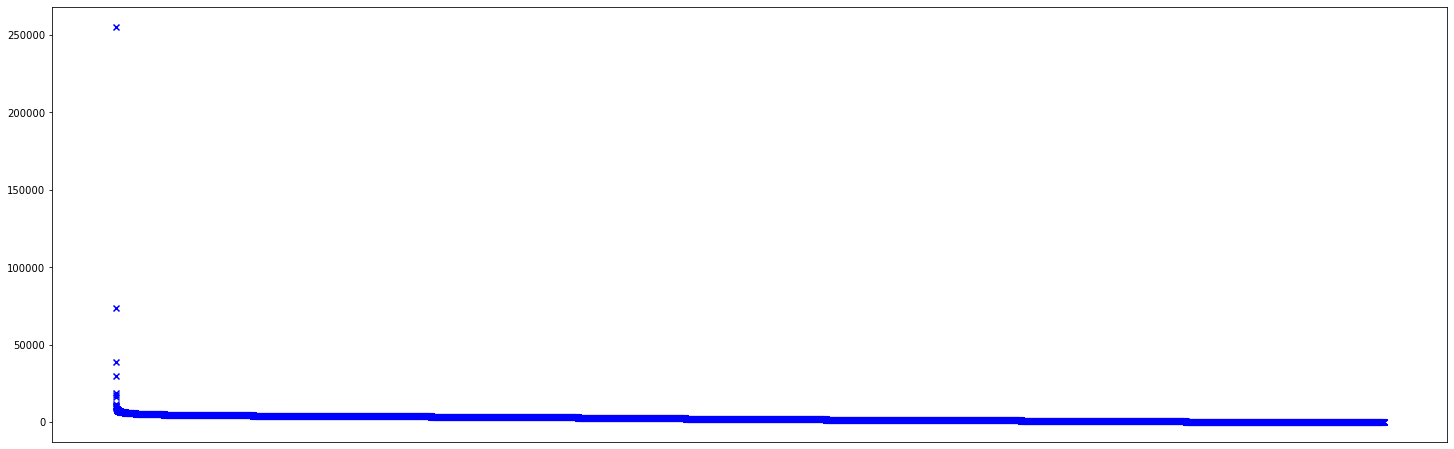

Completed in :0:00:54.714497


In [27]:
dtn()
x=counts[0].loc[:,"UserName"]
y=counts[0].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Blue")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/UserNames_Freq.png")
plt.show()
gen_end()

Once again the end of the data looks as if it's a steady decrease so I had a look at the last 25000 entries (baring in mind there is only 25320 total entries) to see if it is as straight as it seems. It is shown that the decrease in frequency is relatively steady but not completely straight, but still quite consistently large counts of each term appearing!

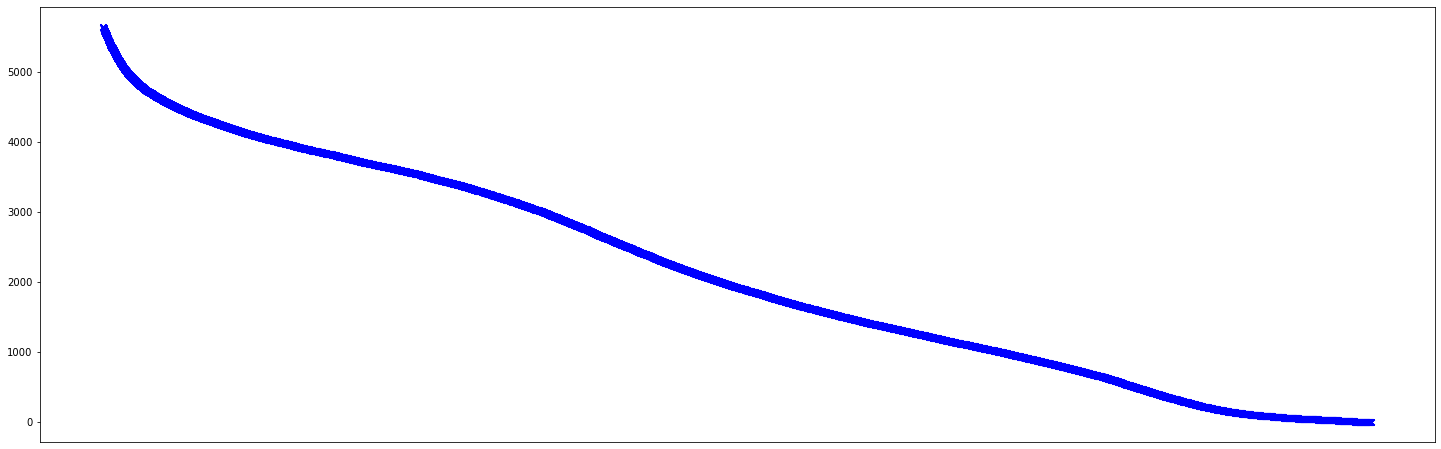

Completed in :0:00:54.158500


In [28]:
dtn()
x=counts[0].loc[:,"UserName"].tail(25000)
y=counts[0].loc[:,"Count"].tail(25000)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Blue")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/UserNames_Tail_25000.png")
plt.show()
gen_end()

I now proceed to plot the top 150, and then the whole data for the remaining features - each represented by a different colour graph.

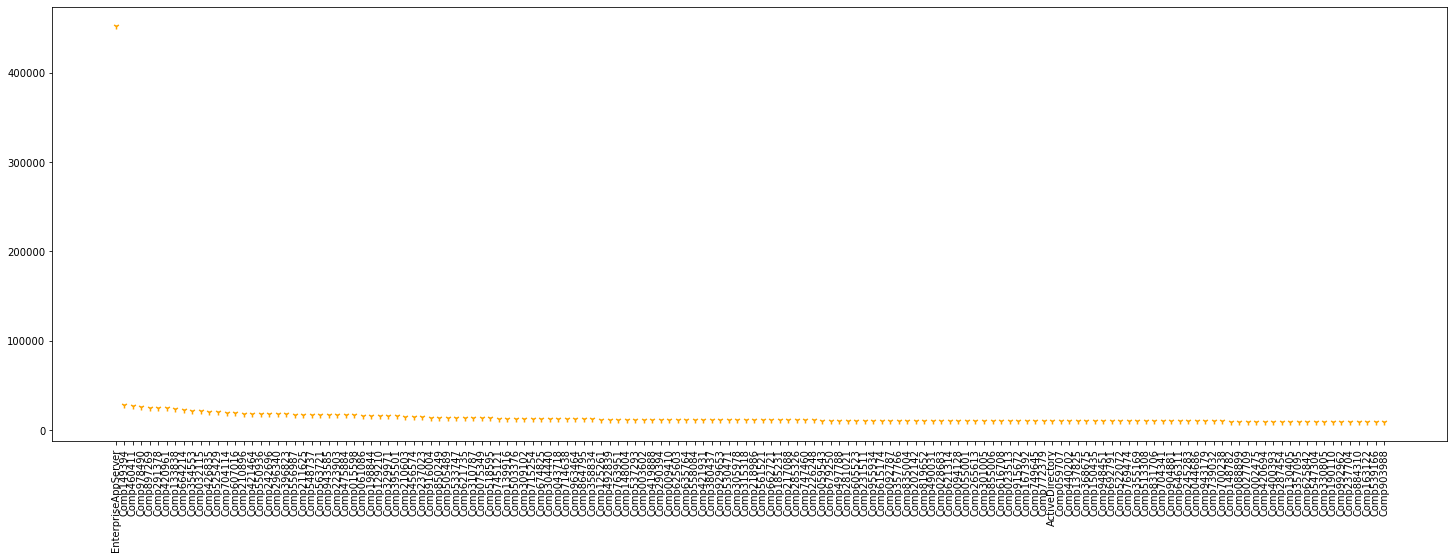

In [29]:
x=counts[1].loc[:,"Device"].head(150)
y=counts[1].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Orange")
plt.xticks(rotation=90)
plt.savefig("./plots/Device_Head_150.png")
plt.show()

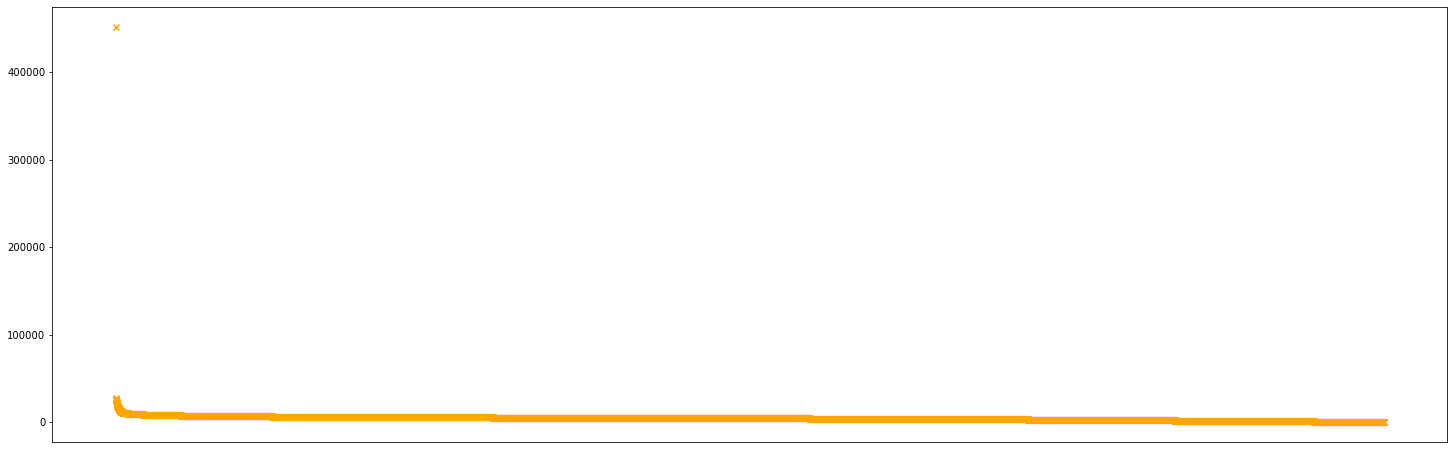

Completed in :0:00:29.646611


In [36]:
dtn()
x=counts[1].loc[:,"Device"]
y=counts[1].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Orange")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/Device_Freq.png")
plt.show()

gen_end()

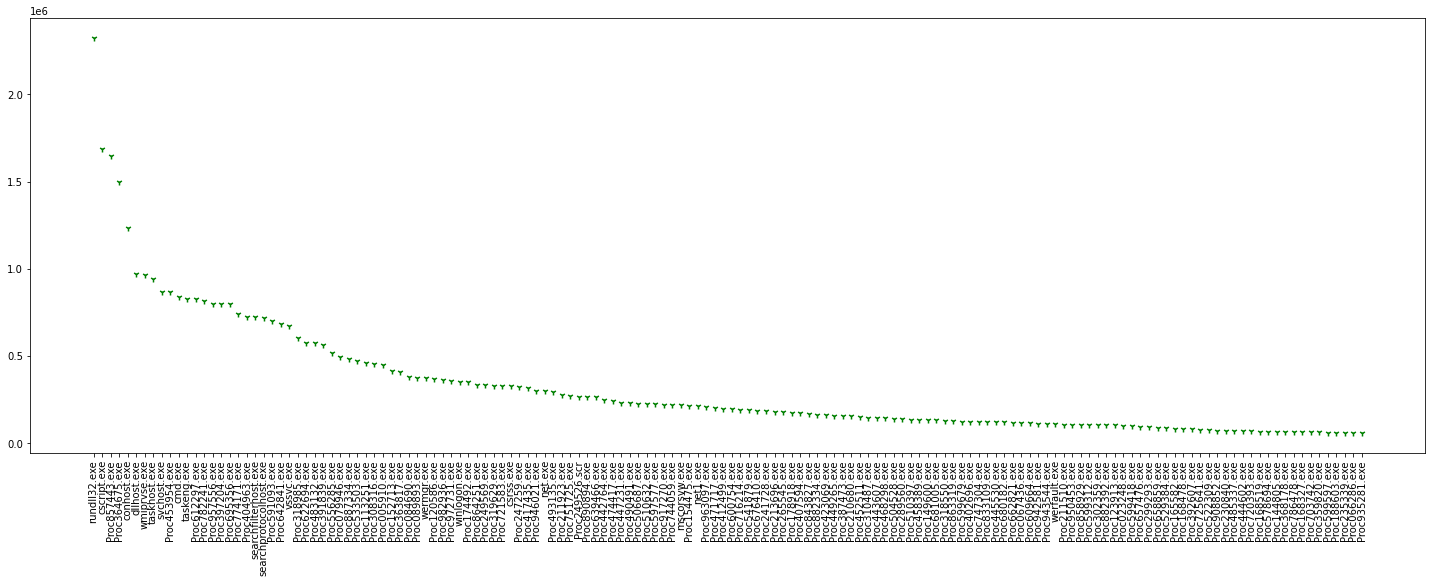

In [31]:
x=counts[2].loc[:,"ProcessName"].head(150)
y=counts[2].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Green")
plt.xticks(rotation=90)
plt.savefig("./plots/ProcessName_Head_150.png")
plt.show()

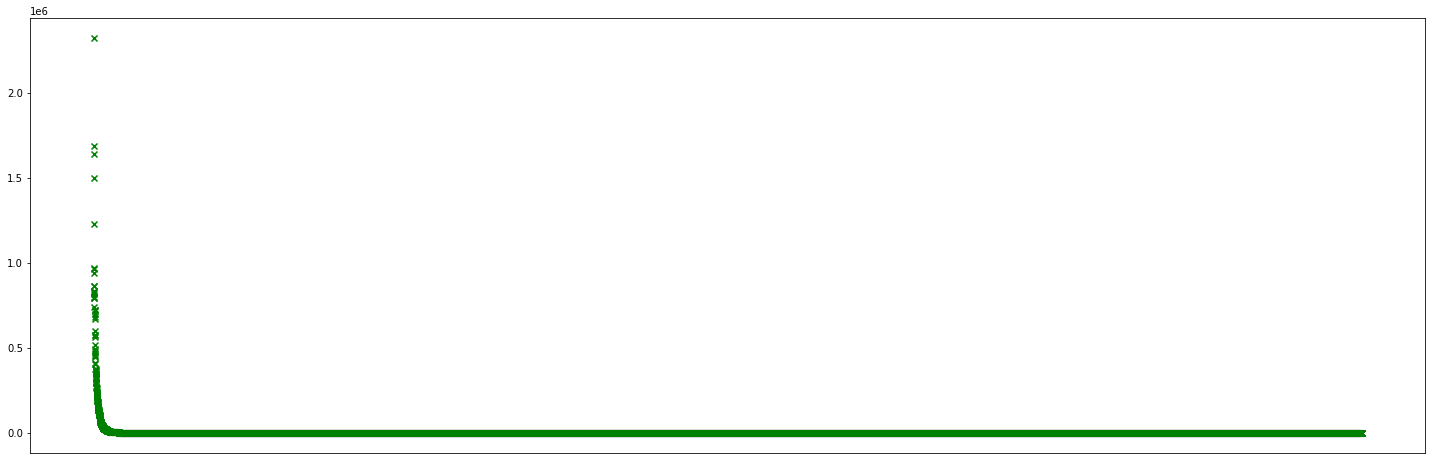

Completed in :0:00:58.066941


In [37]:
dtn()
x=counts[2].loc[:,"ProcessName"]
y=counts[2].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Green")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/ProcessName_Freq.png")
plt.show()

gen_end()

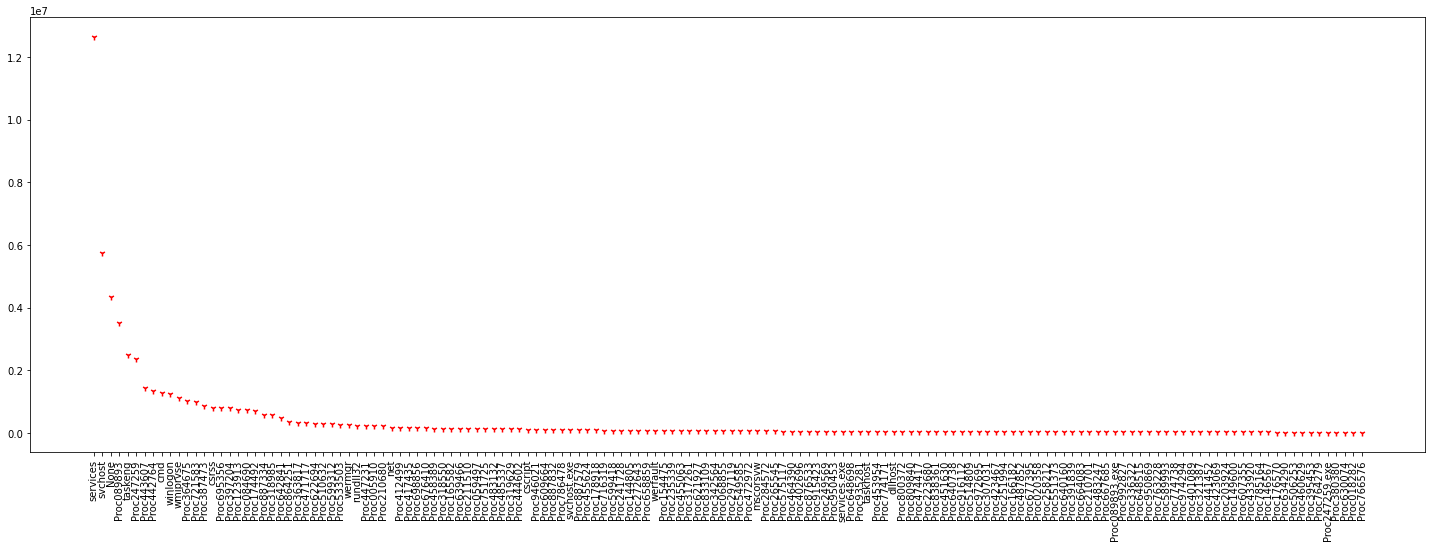

In [33]:
x=counts[3].loc[:,"ParentProcessName"].head(150)
y=counts[3].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Red")
plt.xticks(rotation=90)
plt.savefig("./plots/ParentProcessName_Head_150.png")
plt.show()

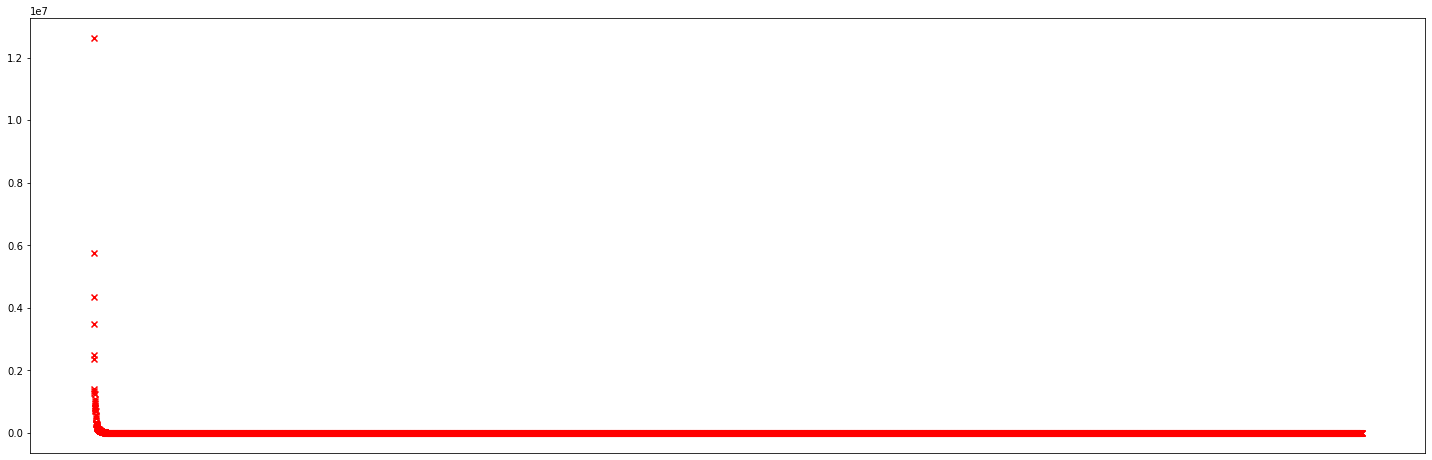

Completed in :0:00:27.505919


In [38]:
dtn()

x=counts[3].loc[:,"ParentProcessName"]
y=counts[3].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Red")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.savefig("./plots/ParentProcessName_Freq.png")
plt.show()

gen_end()

Beneath is an incomplete small test as I wasn't sure whether computers listed as (using the example below) `Comp304440$` Had accidentally added the dollar sign as an additional character however the small test seems to indicate that that is the intended computer name, though I am not sure if there could be any other issues here right now - perhaps worth further investigation to check that there are not the same UserName being logged as different entries.

In [35]:
x=0
y=0
for i in counts[0]["UserName"]:
    if x==0:
        if i == "Comp304440$":
            print("dollar exists")
            x=1
    if y==0:
        if i == "Comp304440":
            print("non-dollar exists")
            y=1

dollar exists


## Network plotting

The below is an attempt at getting the top 100 most occuring UserNames to try and reduce the strain on creating a network plot, however this didn't seem to drastically effect results and I ended up just using the base data for most of the plots that follow.

In [33]:
top_100 = counts[0]["UserName"].head(100)
df_un_top_100 = df_p[df_p.UserName.isin(top_100)]

In [34]:
df_un_top_100

,UserName,Device,ProcessName,ParentProcessName,DailyCount
62,ActiveDirectory$,ActiveDirectory,Proc536347.exe,services,7
89,Comp380437$,Comp380437,searchprotocolhost.exe,Proc443607,73
122,Scanner,Comp547538,Proc453954.exe,cmd,1
146,Scanner,Comp373203,Proc168327.exe,cmd,1
244,Comp948451$,Comp948451,Proc782241.exe,Proc695356,2
...,...,...,...,...,...
55981164,Comp075349$,Comp075349,Proc504528.exe,None,2
55981247,Comp631742$,Comp631742,Proc857443.exe,services,23
55981313,Comp421464$,Comp421464,Proc863319.exe,None,1
55981523,Comp852153$,Comp852153,Proc957556.exe,winlogon,2


In [121]:
df_un_top_100.UserName.describe()

count     1137756
unique        100
top       Scanner
freq       255383
Name: UserName, dtype: object

Here I was attempting to give weight to connections in a network based on how much they occur, again I didn't use this much below but could be worth coming back to. In the `edge_plot` function described below when creating a networkx network, we can add in the `edge_attr` variable alongside `source` and `target` in order to provide weighting to edges based on how frequently they occur.

In [32]:
pd.options.mode.chained_assignment = None
df_un_top_100['Count'] = ""
df_100 = df_un_top_100.groupby(['UserName','Device']).Count.count().reset_index()
df_100.head(20)

,UserName,Device,Count


Below I define a function that creates a network from a pandas dataframe and allows us to specify various variables to suit our needs which are detailed in the function's docstring. As part of this it then creates a network visual using `pyvis`.

In [66]:
top_10000 = counts[0]["UserName"].head(10000)
df_un_top_10000 = df_p[df_p.UserName.isin(top_10000)]

In [27]:
def edge_plot(dfo,sour,targ,ident,hed="complete",show=True):
    """This function creates a network in the networkx package and creates and saves an html plot of the network using pyvis: which can also be specified to be shown within the notebook but this could cause slowdown.
    
    Keyword arguments:
    dfo -- the dataframe to work with.
    sour -- the source nodes for the network \(feature to be used from the dataframe\)
    targ -- the target nodes for the network \(feature to be used from the dataframe\)
    ident -- specifies the name of the plot to be saved, the hed value will also be added afterwards.
    hed -- specify a head of the function to use to test with fewer total values. Use \"complete\" to work on the entire dataframe. DEFAULT = \"complete\"
    show -- specify a boolean for if you want the plot to be shown within the notebook. DEFAULT = False
    """
    dtn()
    hed_on = True
    if hed == "complete":
        G = nx.from_pandas_edgelist(dfo,source=sour,target=targ)
        hed_on = False
    else:
        G = nx.from_pandas_edgelist(dfo.head(hed),source=sour,target=targ)
        hed_on = True
    net = Network(notebook=True)
    net.from_nx(G)
    if hed_on == True:
        if len(dfo.head(hed)) >= 5000:
            net.toggle_physics(False)
        else:
            net.toggle_physics(True)
    if hed_on == False:
        if len(dfo) >= 5000:
            net.toggle_physics(False)
        else:
            net.toggle_physics(True)
    string = "./plots/netx_graphs/plot_"+str(ident)+"_"+str(hed)+".html"
    net.show_buttons(filter_=['physics'])
    finish = net.show(string)
    gen_end()
    if show == True:
        return finish

In [59]:
edge_plot(df_un_top_100,"UserName","Device","df_un_top_100",100)

Completed in :0:00:00.014970


In [62]:
edge_plot(df_un_top_100,"UserName","Device","df_un_top_100",10000)

Completed in :0:00:00.146223


In [63]:
edge_plot(df_un_top_100,"UserName","Device","df_un_top_100",100000,False)

Completed in :0:00:01.281561


The below plot is a plot of the entire network however when loading the plot it is almost impossible to interpret without the physics to seperate the nodes, however turning the physics on is immensley laggy and is difficult to do anything with.

In [38]:
edge_plot(df_un_top_100,"UserName","Device","df_un_top_100","complete",False)

Completed in :0:00:32.504138


In [39]:
edge_plot(df_un_top_10000,"UserName","Device","df_un_top_100000",1000000,False)

Completed in :0:00:30.299874


### Above implemented on processes

In [18]:
top_1000_p = counts[3]["ParentProcessName"].head(1000)
df_pp_1000 = df_p[df_p.ParentProcessName.isin(top_1000_p)]

In [19]:
edge_plot(df_pp_1000,"ParentProcessName","ProcessName","process_network","complete",False)

Completed in :0:06:26.855514


In [28]:
edge_plot(df_pp_1000,"ParentProcessName","ProcessName","process_network",10000,False)

Completed in :0:00:00.154706


In [29]:
edge_plot(df_pp_1000,"ParentProcessName","ProcessName","process_network",20,False)

Completed in :0:00:00.027486


In [30]:
edge_plot(df_pp_1000,"ParentProcessName","ProcessName","process_network",1000000,False)

Completed in :0:00:11.143295


Below bit is new attempt at reducing trivial connections (only 1 connection)

In [117]:
df_un_top_10000_mk2 = df_un_top_10000.drop_duplicates(subset=["UserName","Device"])

In [124]:
df_un_top_10000_mk2.shape

(30505, 5)

In [125]:
df_un_top_10000.shape

(39339537, 5)

In [128]:
#counts_2 = df_un_top_10000_mk.groupby("UserName").size().sort_values(ascending=False)
#counts_2 = pd.DataFrame(z)
#counts_2 = counts_2.drop(["level_0","index"],axis=1)
#counts_2.reset_index(level=0, inplace=True)
#counts_2.columns = ["UserName","Count"]

In [138]:
counts_2 = df_un_top_10000_mk2["UserName"].value_counts()

In [159]:
counts_3 = counts_2[counts_2 > 1]

In [160]:
df_un_top_10000_mk3 = df_un_top_10000_mk2[df_un_top_10000_mk2.UserName.isin(counts_3.index)]

In [161]:
df_un_top_10000_mk3

,UserName,Device,ProcessName,ParentProcessName,DailyCount
15,User851869,Comp445233,Proc915692.exe,Proc318985,1
55,User890930,Comp310787,Proc256172.exe,Proc442764,2
96,User326831,Comp548737,Proc437783.exe,Proc442764,1
122,Scanner,Comp547538,Proc453954.exe,cmd,1
136,User614519,Comp108024,Proc005910.exe,Proc887334,5
...,...,...,...,...,...
55732051,User963614,EnterpriseAppServer,Proc451630.exe,Proc471717,1
55733896,Administrator,Comp833243,Proc208228.exe,Proc208228,1
55736012,User491325,Comp763951,Proc005910.exe,Proc089893,5
55739969,User695833,Comp633447,Proc079020.exe,Proc247259,1


In [201]:
counts4 = df_un_top_10000_mk3["Device"].value_counts()
counts4 = counts4[counts4 > 1]
df_un_top_10000_mk4 = df_un_top_10000_mk3[df_un_top_10000_mk3.Device.isin(counts4.index)]

In [202]:
df_un_top_10000_mk4

,UserName,Device,ProcessName,ParentProcessName,DailyCount
15,User851869,Comp445233,Proc915692.exe,Proc318985,1
96,User326831,Comp548737,Proc437783.exe,Proc442764,1
122,Scanner,Comp547538,Proc453954.exe,cmd,1
136,User614519,Comp108024,Proc005910.exe,Proc887334,5
146,Scanner,Comp373203,Proc168327.exe,cmd,1
...,...,...,...,...,...
55732051,User963614,EnterpriseAppServer,Proc451630.exe,Proc471717,1
55733896,Administrator,Comp833243,Proc208228.exe,Proc208228,1
55736012,User491325,Comp763951,Proc005910.exe,Proc089893,5
55739969,User695833,Comp633447,Proc079020.exe,Proc247259,1


In [199]:
df_un_top_10000_mk3[df_un_top_10000_mk3["UserName"] == "User751030"]

,UserName,Device,ProcessName,ParentProcessName,DailyCount
612382,User751030,EnterpriseAppServer,Proc451630.exe,Proc471717,1
626041,User751030,Comp686168,Proc319629.exe,Proc763228,1


In [200]:
edge_plot(df_un_top_10000_mk[df_un_top_10000_mk3["UserName"] == "User751030"],"UserName","Device","test","complete",False)

Completed in :0:00:00.010980


In [192]:
edge_plot(df_un_top_10000_mk3,"UserName","Device","df_un_top_10000_reduced",10000,False)

Completed in :0:00:15.465525


In [203]:
edge_plot(df_un_top_10000_mk4,"UserName","Device","df_un_top_10000_reduced_both","complete",False)

Completed in :0:00:36.386096


In [204]:
edge_plot(df_un_top_10000_mk4,"UserName","Device","df_un_top_10000_reduced_both",100,False)

Completed in :0:00:00.018465


In [240]:
def edge_plot_2(dfo,sour,targ,ident,hed="complete",ignore=1,show=True,):
    """This function creates a network in the networkx package and creates and saves an html plot of the network using pyvis: which can also be specified to be shown within the notebook but this could cause slowdown.
    
    Keyword arguments:
    dfo -- the dataframe to work with.
    sour -- the source nodes for the network \(feature to be used from the dataframe\)
    targ -- the target nodes for the network \(feature to be used from the dataframe\)
    ident -- specifies the name of the plot to be saved, the hed value will also be added afterwards.
    hed -- specify a head of the function to use to test with fewer total values. Use \"complete\" to work on the entire dataframe. DEFAULT = \"complete\"
    ignore -- don't create a connection for variables that have less than this many connections connection. DEFAULT = 1 
    show -- specify a boolean for if you want the plot to be shown within the notebook. DEFAULT = False
    """
    dtn()
    hed_on = True
    if hed == "complete":
        #counts = dfo[sour].value_counts()
        #counts = counts[counts > ignore]
        #dfo = dfo[dfo[sour].isin(counts.index)]
        
        #counts = dfo[targ].value_counts()
        #counts = counts[counts > ignore]
        #dfo = dfo[dfo[targ].isin(counts.index)]
        
        G = nx.from_pandas_edgelist(dfo,source=sour,target=targ)
        for component in list(nx.connected_components(G)):
            if len(component)<ignore:
                for node in component:
                    G.remove_node(node)
        hed_on = False
    else:
        #dfo = dfo.head(hed)
        #counts = dfo[sour].value_counts()
        #counts = counts[counts > ignore]
        #dfo = dfo[dfo[sour].isin(counts.index)]
        
        #counts = dfo[targ].value_counts()
        #counts = counts[counts > ignore]
        #dfo = dfo[dfo[targ].isin(counts.index)]
        
        G = nx.from_pandas_edgelist(dfo.head(hed),source=sour,target=targ)
        for component in list(nx.connected_components(G)):
            if len(component)<ignore:
                for node in component:
                    G.remove_node(node)
        hed_on = True
    net = Network(notebook=True)
    net.from_nx(G)
    if hed_on == True:
        if len(dfo.head(hed)) >= 5000:
            net.toggle_physics(False)
        else:
            net.toggle_physics(True)
    if hed_on == False:
        if len(dfo) >= 5000:
            net.toggle_physics(False)
        else:
            net.toggle_physics(True)
    string = "./plots/netx_graphs/plot_"+str(ident)+"_"+str(hed)+".html"
    net.show_buttons(filter_=['physics'])
    finish = net.show(string)
    gen_end()
    if show == True:
        return finish

In [190]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_un_top_10000_reduced_1","complete",1,False)

Completed in :0:04:40.248037


In [242]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_un_top_10000_no_1_edge",10000,3,False)

Completed in :0:00:00.266992


In [243]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_un_top_10000_no_1_edge","complete",3,False)

Completed in :0:04:00.494656


In [244]:
edge_plot_2(df_p,"UserName","Device","df_p_no_1_edge","complete",3,False)

KeyboardInterrupt: 

In [249]:
edge_plot_2(df_p,"UserName","Device","df_p_no_1_edge",100000,3,False)

Completed in :0:00:30.560294


In [250]:
edge_plot_2(df_p,"UserName","Device","df_p_no_5_edge",100000,8,False)

Completed in :0:00:01.150340


In [251]:
edge_plot_2(df_p,"UserName","Device","df_p_no_20_edge","complete",22,False)

KeyboardInterrupt: 

In [ ]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_top_10000_no_20_edge","complete",22,False)

In [ ]:
edge_plot_2(df_un_top_100,"UserName","Device","df_top_100_no_20_edge","complete",22,False)

In [246]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_top_10000_1_edge",1000000,3,False)

Completed in :0:00:09.107021


In [245]:
edge_plot_2(df_un_top_10000,"UserName","Device","df_un_top_10000_no_1_edge",100000,3,False)

Completed in :0:00:01.518112


In [193]:
counts_3

User272607       8946
Scanner          2355
Administrator     437
User583334        165
User724397        143
                 ... 
User751030          2
User350352          2
User667644          2
User962712          2
User325667          2
Name: UserName, Length: 860, dtype: int64

In [232]:
G = nx.from_pandas_edgelist(df_un_top_10000.head(100),source="UserName",target="Device")
len(list(nx.connected_components(G)))

96

In [236]:
for component in list(nx.connected_components(G)):
    if len(component)<3:
        for node in component:
            G.remove_node(node)

In [237]:
len(list(nx.connected_components(G)))

1

## Aside into memory usage in Python

An interesting function that defines the total memory each defined variable uses, however it doesn't apply properly for pandas dataframes, use the pandas.info() function also used below.

In [94]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          df_p: 14.5 GiB
                 df_un_top_100: 372.7 MiB
                           _40: 372.7 MiB
                     df_counts:  6.5 MiB
                        df_100:  1.8 MiB
                             z: 899.0 KiB
                             y: 95.7 KiB
                       top_100:  6.8 KiB
                           _14:  4.6 KiB
                           _42:  3.0 KiB


In [86]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
data_quality_report   DataFrame                      Data Ty<...>    15374               0
df_100                DataFrame                   UserName  <...>n[13228 rows x 3 columns]
df_counts             DataFrame                       UserNa<...>n[25373 rows x 8 columns]
df_desc               DataFrame            UserName         <...>2325974          12633664
df_p                  DataFrame                 UserName    <...>5981618 rows x 5 columns]
df_un_top_100         DataFrame                      UserNam<...>1137756 rows x 6 columns]
z                     DataFrame          ParentProcessName  <...>n[12226 rows x 2 columns]


In [92]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55981618 entries, 0 to 55981617
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   UserName           object
 1   Device             object
 2   ProcessName        object
 3   ParentProcessName  object
 4   DailyCount         int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ GB


## References

[Visualising Networks in Python](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)
https://stackoverflow.com/questions/38308865/how-to-remove-small-components-from-a-graph